In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
def clamp(x, lo, hi):
    if x < lo:
        return lo, True
    elif x > hi:
        return hi, True
    return x, False

class x_controller:
    def __init__(self):
        self.x = 0
        self.x_dot = 0
        self.x_ddot = 0

        self.dt = 1/100
        self.rateLimit = 1/10

    def step(self, a):
        self.x_ddot, _ = clamp(a, self.x_ddot - self.rateLimit, self.x_ddot + self.rateLimit)
        self.x_dot += self.dt * self.x_ddot
        self.x += self.dt * self.x_dot
        
        self.x, _ = clamp(self.x, -1 , 1)


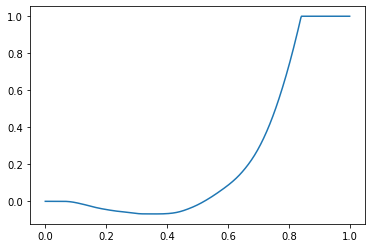

In [10]:
time = 500
from random import random
t = np.linspace(0, 1, time)
x = np.zeros((time,))
c = x_controller()

a = 0

for i in range(time):
    a += (2*random() - 1) * 0.1 #Obeys the torque rampup limits
    c.step(a)
    x[i] = c.x
plt.plot(t, x)

In [11]:
def sample_generator():
    while True:
        controller = x_controller()
        time = 500
        x = np.zeros((500,), dtype=np.float32)
        cmd = np.zeros((500,), dtype=np.float32)
        a = 0
        for i in range(time):
            a += (2*random() - 1) * 0.1 #Obeys the torque rampup limits
            controller.step(a)
            x[i] = controller.x
            cmd[i] = a
        yield x, cmd

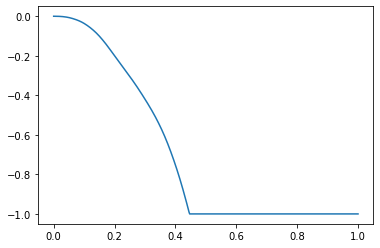

In [15]:
import itertools
gen = sample_generator()
c = [next(gen) for _ in range(1)][0][0]
plt.plot(t, c)

Zdaj imam dober generator testnih primerov. Cas za train_test loaderje...

In [ ]:
import torch
from torch import nn

[-50:50] navorov in [-50:0] pozicij

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(150, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [23]:
gen = sample_generator()
x, a = next(gen)
sample = np.concatenate((x[0:50],a[0:100]))
print(sample.shape)

model = NeuralNetwork()

torch_sample = torch.from_numpy(sample)
print(torch_sample.dtype)
print(model.forward(torch_sample))
print(x[99])

(150,)


NameError: name 'NeuralNetwork' is not defined

Priprava testnih podatkov

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class SimDataset(Dataset):
    def __init__(self, length, i, o):
        self.len = length
        self.i = i
        self.o = o

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.i[idx], self.o[idx]

In [ ]:
generator = sample_generator()

def random_data_dataset(length):
    raw_in = [next(generator) for _ in range(length)]
    #print(len(raw_in))

    i_data = []
    o_data = []
    for i, data in enumerate(raw_in):
        x = data[0]
        a = data[1]
        data_input = np.concatenate((x[0:50], a[0:100]))
        data_output = np.zeros((1,), dtype=np.float32)
        data_output[0]=x[99]
        i_data.append(data_input)
        o_data.append(data_output)
    return SimDataset(length, i_data, o_data)


in_set = random_data_dataset(10000)
out_set = random_data_dataset(1000)

In [ ]:
train_dataloader = DataLoader(in_set, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(out_set, batch_size=64, shuffle=False)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, debug):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if debug:
        loss = loss.item()
        print(f"loss: {loss:>10f}")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>10f} \n")

model = NeuralNetwork()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 100
print(len(train_dataloader))
print(len(test_dataloader))
for t in range(epochs):
    if t%10 == 0:
        print(f"Epoch {t}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, t%10==0)
    if t%10 == 0:
        test_loop(test_dataloader, model, loss_fn)
print("Done!")

Testiranje

In [ ]:
gen = sample_generator()
x, a = next(gen)
sample = np.concatenate((x[0:50],a[0:100]))

torch_sample = torch.from_numpy(sample)

print(model.forward(torch_sample))
print(x[99], (model.forward(torch_sample).item()-x[99])**2)

Na primerih z istim generatorjem dobro dela. Naredimo bolj zanimiv primer

In [ ]:
controller = x_controller()
time = 500
x = np.zeros((500,), dtype=np.float32)
cmd = np.zeros((500,), dtype=np.float32)
a = 0
for i in range(time):
    a += 0.04 if i < 50 else -0.03
    controller.step(a)
    x[i] = controller.x
    cmd[i] = a
plt.plot(np.linspace(0,500,500), x)
plt.plot(np.linspace(0,500,500), cmd)

sample = np.concatenate((x[0:50],cmd[0:100]))

torch_sample = torch.from_numpy(sample)

print(model.forward(torch_sample))
print(x[99], (model.forward(torch_sample).item()-x[99])**2)

Ok stvar izgleda da kar v redu deluje, naslednji projekt: Manj podatkov in zakompliciramo sistem